# MLB For Data Science - Predicting the Strikezone

# Merging, Cleaning, Missing Values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = "dark")

In [2]:
atbats = pd.read_csv("atbats.csv")
atbats_2019 = pd.read_csv("2019_atbats.csv")

In [3]:
atbats = pd.concat([atbats, atbats_2019], axis = 0, sort = True)

In [4]:
atbats.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2.015000e+09,572761,Groundout,201500001.0,1.0,1,0.0,L,452657,L,1.0
1,2.015000e+09,518792,Double,201500001.0,1.0,1,0.0,L,452657,L,1.0
2,2.015000e+09,407812,Single,201500001.0,1.0,1,0.0,L,452657,R,1.0
3,2.015000e+09,425509,Strikeout,201500001.0,1.0,2,0.0,L,452657,R,1.0
4,2.015000e+09,571431,Strikeout,201500001.0,1.0,3,0.0,L,452657,L,1.0


In [5]:
games = pd.read_csv("games.csv")[["g_id", "date", "away_team", "home_team", "away_final_score", "home_final_score", "umpire_HP"]]
games_2019 = pd.read_csv("2019_games.csv")[["g_id", "date", "away_team", "home_team", "away_final_score", "home_final_score", "umpire_HP"]]

In [6]:
games = pd.concat([games, games_2019], axis = 0, sort = True)

In [7]:
games.head()

,away_final_score,away_team,date,g_id,home_final_score,home_team,umpire_HP
0,3.0,sln,2015-04-05,201500001.0,0.0,chn,Mike Winters
1,1.0,ana,2015-04-06,201500002.0,4.0,sea,Larry Vanover
2,2.0,atl,2015-04-06,201500003.0,1.0,mia,Jeff Nelson
3,6.0,bal,2015-04-06,201500004.0,2.0,tba,Dana DeMuth
4,8.0,bos,2015-04-06,201500005.0,0.0,phi,Gerry Davis


In [8]:
pitches = pd.read_csv("pitches.csv")
pitches_2019 = pd.read_csv("2019_pitches.csv")

In [9]:
pitches = pd.concat([pitches, pitches_2019], axis = 0, sort = True)

In [10]:
len(pitches)

3595944

In [11]:
pitches = pitches.replace("placeholder", np.NaN)

In [12]:
names = pd.read_csv("player_names.csv").rename(columns = {"id": "batter_id"})

In [13]:
atbats = pd.merge(atbats, names, on = "batter_id") #getting batter names for each row

In [14]:
atbats["batter_name"] = atbats["first_name"] + " " + atbats["last_name"]

In [15]:
atbats = atbats.drop(columns = ["first_name", "last_name"])

In [16]:
names = names.rename(columns = {"batter_id": "pitcher_id"})

In [17]:
atbats = pd.merge(atbats, names, on = "pitcher_id") #getting pitcher names for each row

In [18]:
atbats["pitcher_name"] = atbats["first_name"] + " " + atbats["last_name"]

In [19]:
atbats = atbats.drop(columns = ["first_name", "last_name"]).sort_values(by = "ab_id")

In [20]:
atbats["year"] = atbats["ab_id"].astype(str).str[:4] #the year is the first 4 digits of at bat id

In [21]:
atbats_games = pd.merge(atbats, games, on = "g_id")

In [22]:
atbats_games["date"] = pd.to_datetime(atbats_games["date"])

In [23]:
atbats_pitches = pd.merge(pitches, atbats_games, on = "ab_id")

In [24]:
atbats_pitches.head()

,ab_id,ax,ay,az,b_count,b_score,break_angle,break_length,break_y,code,...,top,batter_name,pitcher_name,year,away_final_score,away_team,date,home_final_score,home_team,umpire_HP
0,2.015000e+09,7.665,34.685,-11.960,0.0,0.0,-25.0,3.2,23.7,C,...,1.0,Matt Carpenter,Jon Lester,2015,3.0,sln,2015-04-05,0.0,chn,Mike Winters
1,2.015000e+09,12.043,34.225,-10.085,0.0,0.0,-40.7,3.4,23.7,S,...,1.0,Matt Carpenter,Jon Lester,2015,3.0,sln,2015-04-05,0.0,chn,Mike Winters
2,2.015000e+09,14.368,35.276,-11.560,0.0,0.0,-43.7,3.7,23.7,F,...,1.0,Matt Carpenter,Jon Lester,2015,3.0,sln,2015-04-05,0.0,chn,Mike Winters
3,2.015000e+09,2.104,28.354,-20.540,0.0,0.0,-1.3,5.0,23.8,B,...,1.0,Matt Carpenter,Jon Lester,2015,3.0,sln,2015-04-05,0.0,chn,Mike Winters
4,2.015000e+09,-10.280,21.774,-34.111,1.0,0.0,18.4,12.0,23.8,B,...,1.0,Matt Carpenter,Jon Lester,2015,3.0,sln,2015-04-05,0.0,chn,Mike Winters


In [25]:
atbats_pitches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3458953 entries, 0 to 3458952
Data columns (total 59 columns):
ab_id               float64
ax                  float64
ay                  float64
az                  float64
b_count             float64
b_score             float64
break_angle         float64
break_length        float64
break_y             float64
code                object
end_speed           float64
event_num           int64
nasty               float64
on_1b               float64
on_2b               float64
on_3b               float64
outs                float64
pfx_x               float64
pfx_z               float64
pitch_num           float64
pitch_type          object
px                  float64
pz                  float64
s_count             float64
spin_dir            float64
spin_rate           float64
start_speed         float64
sz_bot              float64
sz_top              float64
type                object
type_confidence     float64
vx0                 floa

In [26]:
def missing_props(df):
    missing_values = []
    for i in df.columns:
        missing_values.append(round(df[i].isnull().sum() / len(df), 3))
    missing_props = pd.DataFrame(list(zip(df.columns, missing_values)), columns = ["Var", "Prop_Missing"]).sort_values(by = "Prop_Missing", ascending = False)
    
    return missing_props

In [27]:
missing_props(atbats_pitches)

,Var,Prop_Missing
30,type_confidence,0.175
39,zone,0.175
24,spin_dir,0.175
25,spin_rate,0.175
12,nasty,0.175
58,umpire_HP,0.171
22,pz,0.006
26,start_speed,0.006
1,ax,0.006
31,vx0,0.006


# Feature Engineering

## Strikezone Flag

In [28]:
atbats_pitches["Strikezone?"] = np.where((np.abs(atbats_pitches["px"] * 12) <= 9.97) & (atbats_pitches["pz"] * 12 <= 44.08) & (atbats_pitches["pz"] * 12 >= 18.29), True, False)

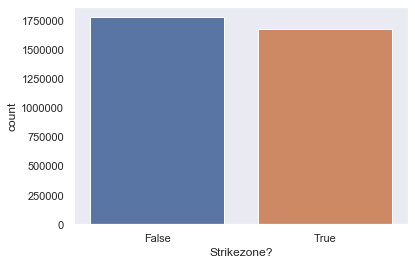

In [29]:
sns.countplot(atbats_pitches["Strikezone?"])

## Batting and Pitching Teams

In [30]:
atbats_pitches["batting_team"] = np.where(atbats_pitches["top"] == 1, atbats_pitches["away_team"], atbats_pitches["home_team"])
atbats_pitches["pitching_team"] = np.where(atbats_pitches["top"] == 1, atbats_pitches["home_team"], atbats_pitches["away_team"])

## Ball Types

In [31]:
atbats_pitches["Z Call"] = np.where(atbats_pitches["pz"] * 12 >= 44.08, "High", np.where(atbats_pitches["pz"] * 12 <= 18.29, "Low", np.NaN))

In [32]:
atbats_pitches["X Call"] = np.where(((atbats_pitches["px"] * 12 <= -9.97) & (atbats_pitches["stand"] == "L")) | ((atbats_pitches["px"] * 12 >= 9.97) & (atbats_pitches["stand"] == "R")), "Outside", np.where(((atbats_pitches["px"] * 12 <= -9.97) & (atbats_pitches["stand"] == "R")) | ((atbats_pitches["px"] * 12 >= 9.97) & (atbats_pitches["stand"] == "L")), "Inside", np.NaN))
                                    
                                    

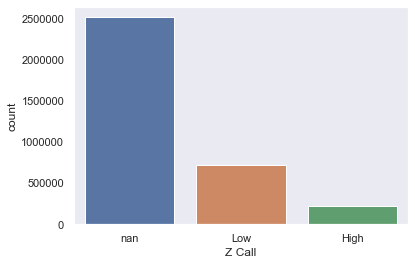

In [33]:
sns.countplot(atbats_pitches["Z Call"])

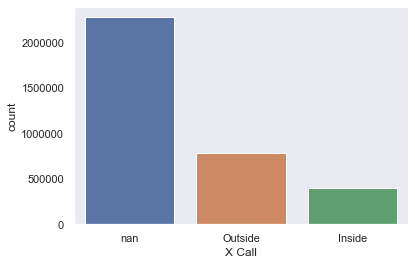

In [34]:
sns.countplot(atbats_pitches["X Call"])

In [35]:
outside = atbats_pitches[atbats_pitches["X Call"] == "Outside"]
inside = atbats_pitches[atbats_pitches["X Call"] == "Inside"]

In [36]:
len(outside[outside["code"] == "P"])

652

In [37]:
len(inside[inside["code"] == "P"])

0

In [38]:
atbats_pitches["Location"] = np.where((atbats_pitches["X Call"] == "nan") & (atbats_pitches["Z Call"] != "nan"), atbats_pitches["Z Call"], np.where((atbats_pitches["Z Call"] == "nan") & (atbats_pitches["X Call"] != "nan"), atbats_pitches["X Call"], np.where((atbats_pitches["X Call"] != "nan") & (atbats_pitches["Z Call"] != "nan"), atbats_pitches["Z Call"] + " and " + atbats_pitches["X Call"], "Strikezone")))



In [39]:
atbats_pitches = atbats_pitches.drop(columns = ["X Call", "Z Call"])

## Cumulative Averages

In [40]:
atbats_pitches["ab_id"] = atbats_pitches["ab_id"].astype(str)

In [41]:
events = atbats_pitches[["ab_id", "date", "pitcher_name", "batter_name", "event"]].drop_duplicates()

### Creating Event Flags

In [42]:
events["year"] = events["date"].dt.year

events["PA?"] = np.where(events["event"].isin(["Runner Out"]), 0, 1)
events["AB?"] = np.where(events["event"].isin(["Walk", "Intent Walk", "Sac Fly", "Sac Fly DP", "Sac Bunt", "Sacrifice Bunt DP", "Batter Interference", "Catcher Interference", "Runner Out", "Hit By Pitch"]), 0, 1)

events["Hit?"] = np.where(events["event"].isin(["Single", "Double", "Triple", "Home Run"]), 1, 0)
events["Single?"] = np.where(events["event"].isin(["Single"]), 1, 0)
events["Double?"] = np.where(events["event"].isin(["Double"]), 1, 0)
events["Triple?"] = np.where(events["event"].isin(["Triple"]), 1, 0)
events["Home Run?"] = np.where(events["event"].isin(["Home Run"]), 1, 0)
events["Walk?"] = np.where(events["event"].isin(["Walk"]), 1, 0)
events["Intent Walk?"] = np.where(events["event"].isin(["Intent Walk"]), 1, 0)
events["HBP?"] = np.where(events["event"].isin(["Hit By Pitch"]), 1, 0)
events["Sac Fly?"] = np.where(events["event"].isin(["Sac Fly", "Sac Fly DP"]), 1, 0)

events = events.reset_index().drop(columns = "index")

In [43]:
events.head()

,ab_id,date,pitcher_name,batter_name,event,year,PA?,AB?,Hit?,Single?,Double?,Triple?,Home Run?,Walk?,Intent Walk?,HBP?,Sac Fly?
0,2015000001.0,2015-04-05,Jon Lester,Matt Carpenter,Groundout,2015,1,1,0,0,0,0,0,0,0,0,0
1,2015000002.0,2015-04-05,Jon Lester,Jason Heyward,Double,2015,1,1,1,0,1,0,0,0,0,0,0
2,2015000003.0,2015-04-05,Jon Lester,Matt Holliday,Single,2015,1,1,1,1,0,0,0,0,0,0,0
3,2015000004.0,2015-04-05,Jon Lester,Jhonny Peralta,Strikeout,2015,1,1,0,0,0,0,0,0,0,0,0
4,2015000005.0,2015-04-05,Jon Lester,Matt Adams,Strikeout,2015,1,1,0,0,0,0,0,0,0,0,0


### Batter Averages

In [44]:
cum_sum_batters = events.groupby(["year", "batter_name"]).cumsum().reset_index().drop(columns = "index")

In [45]:
indices = events[["ab_id", "date", "pitcher_name", "batter_name"]]

In [46]:
events2 = pd.concat([indices, cum_sum_batters], axis = 1)

In [47]:
events2["Batter AB"] = events2["AB?"]

events2["Batter AVG"] = round(events2["Hit?"] / events2["AB?"], 3)

events2["Batter OBP"] = round((events2["Hit?"] + events2["Walk?"] + events2["Intent Walk?"] + events2["HBP?"]) / (events2["AB?"] + events2["Walk?"] + events2["HBP?"] + events2["Intent Walk?"] + events2["Sac Fly?"]), 3)

events2["Batter TB"] = events2["Single?"] + (2*events2["Double?"]) + (3*events2["Triple?"]) + (4*events2["Home Run?"]) 
events2["Batter SLG"] = round(events2["Batter TB"] / events2["AB?"], 3)

events2["Batter OPS"] = events2["Batter OBP"] + events2["Batter SLG"]


In [48]:
batter_stats = events2[["ab_id", "date", "pitcher_name", "batter_name", "Batter AB", "Batter AVG", "Batter OBP", "Batter SLG", "Batter OPS"]]

### Pitcher Averages

In [49]:
cum_sum_pitchers = events.groupby(["year", "pitcher_name"]).cumsum().reset_index().drop(columns = "index")

In [50]:
events3 = pd.concat([indices, cum_sum_pitchers], axis = 1)

In [51]:
events3["Pitcher AB"] = events3["AB?"]

events3["Pitcher AVG"] = round(events3["Hit?"] / events3["AB?"], 3)

events3["Pitcher OBP"] = round((events3["Hit?"] + events3["Walk?"] + events3["Intent Walk?"] + events3["HBP?"]) / (events3["AB?"] + events3["Walk?"] + events3["HBP?"] + events3["Intent Walk?"] + events3["Sac Fly?"]), 3)

events3["Pitcher TB"] = events3["Single?"] + (2*events3["Double?"]) + (3*events3["Triple?"]) + (4*events3["Home Run?"]) 
events3["Pitcher SLG"] = round(events3["Pitcher TB"] / events3["AB?"], 3)

events3["Pitcher OPS"] = events3["Pitcher OBP"] + events3["Pitcher SLG"]


In [52]:
pitcher_stats = events3[["ab_id", "date", "pitcher_name", "batter_name", "Pitcher AB", "Pitcher AVG", "Pitcher OBP", "Pitcher SLG", "Pitcher OPS"]]


In [53]:
all_avgs = pd.merge(batter_stats, pitcher_stats, on = ["ab_id", "date", "pitcher_name", "batter_name"])

In [54]:
all_avgs.tail()

,ab_id,date,pitcher_name,batter_name,Batter AB,Batter AVG,Batter OBP,Batter SLG,Batter OPS,Pitcher AB,Pitcher AVG,Pitcher OBP,Pitcher SLG,Pitcher OPS
890869,2019185240.0,2019-09-28,Jalen Beeks,Jonathan Davis,69,0.188,0.250,0.246,0.496,372,0.282,0.355,0.441,0.796
890870,2019185241.0,2019-09-28,Jalen Beeks,Danny Jansen,314,0.220,0.289,0.389,0.678,373,0.282,0.354,0.440,0.794
890871,2019185242.0,2019-09-28,Jalen Beeks,Richard Urena,67,0.254,0.286,0.343,0.629,374,0.281,0.353,0.439,0.792
890872,2019185244.0,2019-09-28,Ken Giles,Matt Duffy,119,0.252,0.331,0.336,0.667,174,0.201,0.272,0.328,0.600
890873,2019185245.0,2019-09-28,Ken Giles,Michael Perez,42,0.190,0.320,0.286,0.606,175,0.200,0.271,0.326,0.597


In [55]:
all_avgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890874 entries, 0 to 890873
Data columns (total 14 columns):
ab_id           890874 non-null object
date            890874 non-null datetime64[ns]
pitcher_name    890874 non-null object
batter_name     890874 non-null object
Batter AB       890874 non-null int64
Batter AVG      890359 non-null float64
Batter OBP      890712 non-null float64
Batter SLG      890359 non-null float64
Batter OPS      890359 non-null float64
Pitcher AB      890874 non-null int64
Pitcher AVG     890371 non-null float64
Pitcher OBP     890863 non-null float64
Pitcher SLG     890371 non-null float64
Pitcher OPS     890371 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(3)
memory usage: 102.0+ MB


## Game Situation Statistics

### Inning, Top or Bottom of Inning, Outs, Teams

In [56]:
game_stats = atbats_pitches[["ab_id", "b_count", "s_count", "outs", "inning", "top", "pitching_team", "batting_team", "on_1b", "on_2b", "on_3b", "p_throws", "stand"]]

In [57]:
game_stats2 = pd.merge(all_avgs, game_stats, on = "ab_id", how = "left")

### Count

In [58]:
game_stats2["b_count"] = game_stats2["b_count"].astype(str)
game_stats2["s_count"] = game_stats2["s_count"].astype(str)


game_stats2["Count"] = game_stats2["b_count"] + "-" + game_stats2["s_count"]

### Same Side?

In [59]:
game_stats2["Same Side?"] = game_stats2["p_throws"] == game_stats2["stand"]

### Bases Occupied

In [60]:
game_stats2["Bases Occupied"] = np.where((game_stats2["on_1b"] == 1) & (game_stats2["on_2b"] == 1) & (game_stats2["on_3b"] == 1), "Bases Loaded", np.where((game_stats2["on_1b"] == 1) & (game_stats2["on_2b"] == 1) & (game_stats2["on_3b"] == 0), "1st and 2nd", np.where((game_stats2["on_1b"] == 1) & (game_stats2["on_2b"] == 0) & (game_stats2["on_3b"] == 1), "1st and 3rd", np.where((game_stats2["on_1b"] == 0) & (game_stats2["on_2b"] == 1) & (game_stats2["on_3b"] == 1), "2nd and 3rd", np.where((game_stats2["on_1b"] == 1) & (game_stats2["on_2b"] == 0) & (game_stats2["on_3b"] == 0), "1st", np.where((game_stats2["on_1b"] == 0) & (game_stats2["on_2b"] == 1) & (game_stats2["on_3b"] == 0), "2nd", np.where((game_stats2["on_1b"] == 0) & (game_stats2["on_2b"] == 0) & (game_stats2["on_3b"] == 1), "3rd", "Bases Empty")))))))



### Score Difference

In [61]:
atbats_pitches["Score Diff"] = atbats_pitches["p_score"] - atbats_pitches["b_score"]

In [62]:
game_stats2["Score Diff"] = atbats_pitches["Score Diff"]

In [63]:
game_stats3 = game_stats2.drop(columns = ["on_1b", "on_2b", "on_3b", "b_count", "s_count"])

## Previous Pitch Statistics

### Pitch Number of At-Bat

In [64]:
game_stats3["Pitch Num"] = atbats_pitches["pitch_num"]

In [65]:
game_stats3["Pitch Num"] = game_stats3["Pitch Num"].astype(str)

### Previous Pitch Code, Type, Location, Event, and Zone

In [66]:
atbats_pitches["Previous Code"] = atbats_pitches["code"].shift(periods = 1)
atbats_pitches["Previous Location"] = atbats_pitches["Location"].shift(periods = 1)
atbats_pitches["Previous Type"] = atbats_pitches["pitch_type"].shift(periods = 1)

atbats["ab_id"] = atbats["ab_id"].astype(str)
atbats["Previous Event"] = atbats["event"].shift(periods = 1)

In [67]:
atbats_pitches["pitch_id"] = atbats_pitches.index

In [68]:
first_pitch_inning = list(atbats_pitches[["g_id", "pitch_id", "inning", "top"]].groupby(["g_id", "inning", "top"]).first().reset_index()["pitch_id"])

first_event_inning = list(atbats[["g_id", "ab_id", "inning", "top"]].groupby(["g_id", "inning", "top"]).first().reset_index()["ab_id"])


In [69]:
atbats_pitches["Previous Code"] = np.where(atbats_pitches["pitch_id"].isin(first_pitch_inning), "First Pitch", atbats_pitches["Previous Code"])

atbats_pitches["Previous Location"] = np.where(atbats_pitches["pitch_id"].isin(first_pitch_inning), "First Pitch", atbats_pitches["Previous Location"])

atbats_pitches["Previous Type"] = np.where(atbats_pitches["pitch_id"].isin(first_pitch_inning), "First Pitch", atbats_pitches["Previous Type"])

atbats["Previous Event"] = np.where(atbats["ab_id"].isin(first_event_inning), "First Event", atbats["Previous Event"])


In [70]:
game_stats3["Previous Code"] = atbats_pitches["Previous Code"]

game_stats3["Previous Location"] = atbats_pitches["Previous Location"]

game_stats3["Previous Type"] = atbats_pitches["Previous Type"]

previous_events = atbats[["ab_id", "Previous Event"]]
game_stats3 = pd.merge(game_stats3, previous_events, on = "ab_id")

## Other Statistics

### Year and Month

In [71]:
game_stats3["year"] = atbats_pitches["date"].dt.year.astype(str)
game_stats3["month"] = atbats_pitches["date"].dt.month.astype(str)

### Pitch Number of Game

In [72]:
cum_count = list(atbats_pitches[["g_id", "pitcher_name"]].groupby(["g_id", "pitcher_name"]).cumcount())

In [73]:
game_stats3["Pitch Count"] = np.array(cum_count) + 1

### Strikezone Percentage of Game

In [74]:
atbats_pitches["Pitch Count"] = np.array(cum_count) + 1

atbats_pitches["Strikezone?"] = np.where(atbats_pitches["Strikezone?"] == True, 1, 0)

In [75]:
cum_count2 = atbats_pitches[["g_id", "pitcher_name", "Strikezone?"]].groupby(["g_id", "pitcher_name"]).cumsum()

In [76]:
atbats_pitches["Strike Count"] = cum_count2

atbats_pitches["Strike Prop"] = atbats_pitches["Strike Count"] / atbats_pitches["Pitch Count"]

In [77]:
atbats_pitches_sort = atbats_pitches.sort_values(by = ["g_id", "pitcher_name", "Pitch Count"])

atbats_pitches_sort["Strike Prop"] = atbats_pitches_sort["Strike Prop"].shift(periods = 1)

In [78]:
first_pitch_game = list(atbats_pitches[["g_id", "pitcher_name", "pitch_id"]].groupby(["g_id", "pitcher_name"]).first()["pitch_id"])

In [79]:
atbats_pitches_sort["Strike Prop"] = np.where(atbats_pitches_sort["pitch_id"].isin(first_pitch_game), 0, atbats_pitches_sort["Strike Prop"])

game_stats3["Strike Prop"] = atbats_pitches_sort["Strike Prop"]

## Adding Strikezone Flag (Target Variable)

In [80]:
game_stats3["Strikezone"] = atbats_pitches["Strikezone?"]

game_stats3["Strikezone"] = np.where(game_stats3["Strikezone"] == True, 1, 0)

In [81]:
len(game_stats3)

3458953

In [82]:
len(atbats_pitches)

3458953

## Filtering

### Intentional Walks

In [83]:
events = atbats_pitches[["ab_id", "event"]].drop_duplicates()

In [84]:
game_stats4 = pd.merge(game_stats3, events, on = "ab_id")

game_stats5 = game_stats4[game_stats4["event"] != "Intent Walk"].drop(columns = ["ab_id", "event", "date"])

In [85]:
len(game_stats5)

3441031

### Uncommon Categorical Values

In [86]:
cat_columns = game_stats5.select_dtypes("object").columns

In [87]:
for i in cat_columns:
    flags = pd.DataFrame(game_stats5[i].value_counts() < 1000)
    drop = flags[flags[i] == True].index
    game_stats5 = game_stats5[~game_stats5[i].isin(drop)]

In [88]:
len(game_stats5)

3024752

### Low Sample Sizes of At Bats

In [89]:
game_stats5 = game_stats5[(game_stats5["Batter AB"] >= 30) & (game_stats5["Pitcher AB"] >= 30)]

In [90]:
len(game_stats5)

2574668

# Modeling 

In [250]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler 

from numpy import argmax

import warnings
warnings.filterwarnings("ignore")

## A General Model (Logistic Regression)

In [92]:
stats_sample = game_stats5.sample(n = 500000).drop(columns = ["pitcher_name", "batter_name"])

In [93]:
stats_sample["Strikezone"].value_counts() / len(stats_sample)

0    0.513466
1    0.486534
Name: Strikezone, dtype: float64

In [94]:
no_players_dummies = pd.get_dummies(stats_sample)

In [95]:
no_players_dummies.shape

(500000, 186)

In [96]:
x_vals = no_players_dummies.drop(columns = "Strikezone").fillna(0)
y_val = no_players_dummies["Strikezone"].values

In [97]:
scaler = StandardScaler() 
x_vals_scaled = scaler.fit_transform(x_vals)

In [146]:
x_train, x_test, y_train, y_test = train_test_split(x_vals_scaled, y_val, test_size = 0.2, random_state = 0)

In [147]:
mod1 = LogisticRegression()

In [148]:
mod1.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Cross Validation Score

In [149]:
train_score1 = cross_val_score(mod1, x_train, y_train, cv = 5)
test_score1 = cross_val_score(mod1, x_test, y_test, cv = 5)

In [150]:
np.mean(train_score1), np.mean(test_score1)

(0.5667650011603655, 0.565700028064225)

### Confusion Matrix

In [222]:
y_true = y_val
y_pred = mod1.predict(x_vals_scaled)

In [223]:
matrix = confusion_matrix(y_true, y_pred)
matrix

array([[146506, 110227],
       [105730, 137537]])

In [226]:
tn = matrix[0][0]
fn = matrix[1][0]
tp = matrix[1][1]
fp = matrix[0][1]

### Precision

In [227]:
tp / (tp + fp)

0.5551129300463344

Out of all values that were predicted to be in the strikezone, 55.5% of them were correct.

### Recall / Sensitivity

In [228]:
tp / (tp + fn)

0.5653746706293907

Out of all actual strikezone pitches, 56.5% of them were identified correctly.

### Specificity

In [229]:
tn / (tn + fp)

0.570655116404981

Out of all actual non-strikezone pitches, 57.1% were identified correctly.

### f1-score

In [230]:
f1_score(y_true, y_pred)

0.5601968103846804

### ROC-AUC Curve

In [257]:
prob = mod1.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, prob)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, x = roc_curve(y_test, random_probs, pos_label = 1)

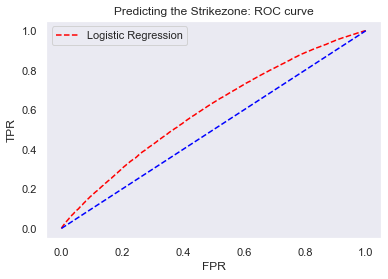

In [258]:
plt.plot(fpr, tpr, linestyle = '--',color = 'red', label = 'Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.title('Predicting the Strikezone: ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'best')
plt.show()

In [259]:
roc_auc_score(y_true, y_pred)

0.5680148935171859

### Optimal Threshold

In [260]:
gmeans = np.sqrt(tpr * (1-fpr))

In [261]:
ix = argmax(gmeans)

In [262]:
thresholds[ix], gmeans[ix]

(0.49576729495465766, 0.568607551678965)

### Changing the Classification Threshold

In [205]:
prob_full = mod1.predict_proba(x_vals_scaled)[:, 1]

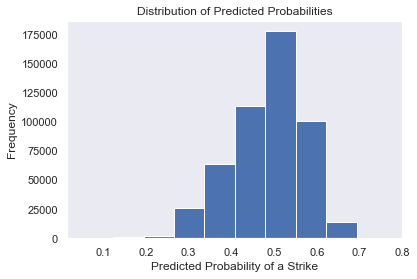

In [270]:
plt.hist(prob_full)
plt.xlabel("Predicted Probability of a Strike")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()

In [239]:
def get_threshold_stats(y_true, probs, thres):
    
    new_y_pred = [1 if i >= thres else 0 for i in probs]
    
    matrix = confusion_matrix(y_true, new_y_pred)
    tn = matrix[0][0]
    fn = matrix[1][0]
    tp = matrix[1][1]
    fp = matrix[0][1]
    
    print(f"Accuracy Score: {(tp + tn) / (tp + tn + fp + fn)}")
    print(f"Precision: {tp / (tp + fp)}")
    print(f"Recall/Sensitivity (TPR): {tp / (tp + fn)}")
    print(f"Specificity: {tn / (tn + fp)}")
    print(f"f1 Score: {f1_score(y_true, new_y_pred)}")

In [265]:
game_stats3["Previous Code"].value_counts() / len(game_stats3)

B              3.333078e-01
F              1.737263e-01
C              1.626333e-01
S              8.470974e-02
X              7.370930e-02
First Pitch    6.152295e-02
D              4.031625e-02
*B             2.301245e-02
E              2.188466e-02
T              7.310305e-03
W              5.760703e-03
L              2.848550e-03
V              2.556554e-03
H              2.442358e-03
I              1.904623e-03
M              6.108785e-04
P              1.827142e-04
O              5.782096e-06
Q              1.445524e-06
R              5.782096e-07
Z              2.891048e-07
Name: Previous Code, dtype: float64

In [269]:
get_threshold_stats(y_true, prob_full, 0.55)

Accuracy Score: 0.555896
Precision: 0.5905965751377205
Recall/Sensitivity (TPR): 0.2842555710392285
Specificity: 0.8132885137477457
f1 Score: 0.3837914039605719


### Feature Importance

In [133]:
c = list(x_vals.columns)

imp1 = pd.DataFrame(c, mod1.coef_[0]).reset_index().sort_values(by = "index", ascending = False)

imp1 = imp1.rename(columns = {0: "Feature", "index": "Importance"})
imp1["Importance"] = imp1["Importance"] ** 2

imp1 = imp1[["Feature", "Importance"]].head(20)

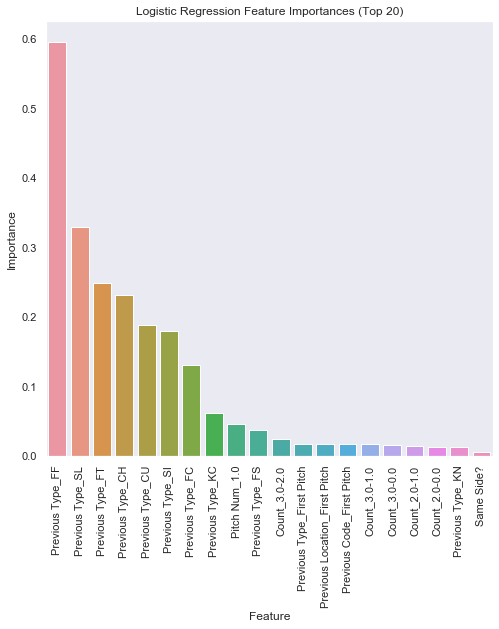

In [136]:
plt.figure(figsize = (8,8))
sns.barplot(imp1["Feature"], imp1["Importance"])
plt.title("Logistic Regression Feature Importances (Top 20)")
plt.xticks(rotation = 90)
plt.show()

## Modeling Individual Pitchers

In [120]:
def model_pitcher(game_stats5, pitcher, mod):
    
    ind_pitcher = game_stats5[game_stats5["pitcher_name"] == pitcher].drop(columns = ["pitcher_name", "batter_name"])
    
    ind_pitcher_dummies = pd.get_dummies(ind_pitcher)
    
    x_vals = ind_pitcher_dummies.drop(columns = "Strikezone").fillna(0)
    y_val = ind_pitcher_dummies["Strikezone"].values
    
    train_array = []
    test_array = []
    
    for i in range(1):
    
        x_train, x_test, y_train, y_test = train_test_split(x_vals, y_val, test_size = 0.4)
    
        mod.fit(x_train, y_train)
    
        train_score = mod.score(x_train, y_train)
        test_score = mod.score(x_test, y_test)
        
        train_array.append(train_score)
        test_array.append(test_score)
        
    baseline = len(ind_pitcher_dummies[ind_pitcher_dummies["Strikezone"] == 1]) / len(ind_pitcher_dummies)
    
    return pitcher, round(baseline, 4), round(np.mean(train_array), 4), round(np.mean(test_array), 4)

    

In [121]:
top100_pitchers = list(game_stats5[["pitcher_name"]].groupby("pitcher_name").size().sort_values(ascending = False).index[0:100])

In [122]:
pitcher_models = [model_pitcher(game_stats5, i, LogisticRegression()) for i in top100_pitchers]

In [123]:
model_df = pd.DataFrame(pitcher_models)

model_df[1] = np.where(model_df[1] < 0.5, 1 - model_df[1], model_df[1])

In [124]:
model_df["Spread"] = model_df[3] - model_df[1]

In [125]:
model_df = model_df.rename(columns = {0: "Pitcher", 1: "Baseline", 2: "Train Accuracy", 3: "Test Accuracy"})

In [126]:
model_df_top_acc = model_df.sort_values(by = "Test Accuracy", ascending = False).head(10)
model_df_bot_acc = model_df.sort_values(by = "Test Accuracy").head(10)

model_df_top_spread = model_df.sort_values(by = "Spread", ascending = False).head(10)
model_df_bot_spread = model_df.sort_values(by = "Spread").head(10)

### Plotting Model Effectiveness

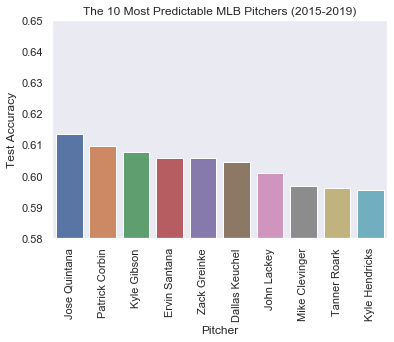

In [127]:
sns.barplot(model_df_top_acc["Pitcher"], model_df_top_acc["Test Accuracy"])
plt.xticks(rotation = 90)
plt.title("The 10 Most Predictable MLB Pitchers (2015-2019)")
plt.ylim(0.58, 0.65)
plt.show()

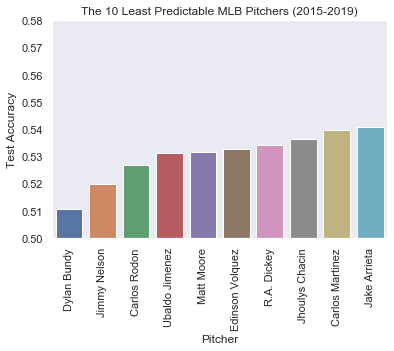

In [128]:
sns.barplot(model_df_bot_acc["Pitcher"], model_df_bot_acc["Test Accuracy"])
plt.xticks(rotation = 90)
plt.title("The 10 Least Predictable MLB Pitchers (2015-2019)")
plt.ylim(0.5, 0.58)
plt.show()

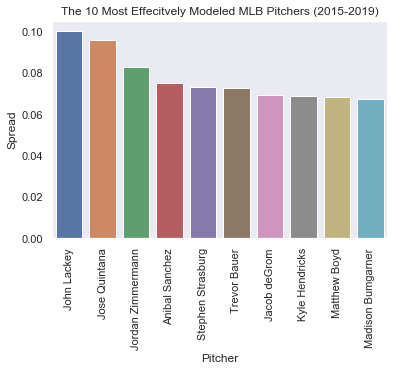

In [129]:
sns.barplot(model_df_top_spread["Pitcher"], model_df_top_spread["Spread"])
plt.xticks(rotation = 90)
plt.title("The 10 Most Effecitvely Modeled MLB Pitchers (2015-2019)")
plt.show()

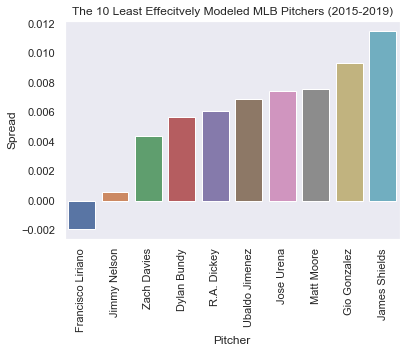

In [130]:
sns.barplot(model_df_bot_spread["Pitcher"], model_df_bot_spread["Spread"])
plt.xticks(rotation = 90)
plt.title("The 10 Least Effecitvely Modeled MLB Pitchers (2015-2019)")
plt.show()